# Analyse predictions

In [1]:
from toolbox import *

import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

import random
import pickle
import glob
import os

In [2]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

## Load model predictions

In [3]:
gs = load_groundwater_station_data('./data/groundwater/bergstraße/gw_stations_bergstraße.csv')
gs = gs[['station_id', 'geometry']]
gs.head()

,station_id,geometry
0,12890,POINT (8.42892 49.70283)
1,12891,POINT (8.48631 49.70426)
2,12892,POINT (8.38953 49.70415)
3,12893,POINT (8.46023 49.70451)
4,12894,POINT (8.40465 49.70432)


In [4]:
pred_folder = './data/predictions'
past_data_path = './data/predictions/past_data.feather'
predictions = {}

# load predictions data
for path in glob.iglob(f'{pred_folder}/add*.feather'):
    pred_name = os.path.splitext(os.path.basename(path))[0]
    print(pred_name)#, path)
    p = pd.read_feather(path)
    p = pd.merge(p, gs, how='left', on='station_id')
    predictions[pred_name] = p

# load past data
past = pd.read_feather(past_data_path)
past = pd.merge(past, gs, how='left', on='station_id')
past = past.loc[past['date'] >= pd.to_datetime('1974-01-01')]
past = past.loc[past['date'] <= pd.to_datetime('2000-12-31')]
predictions['past_data'] = past

add_t+4_p+10
add_ref
add_t+4_p-10


In [5]:
past = predictions['past_data'].set_index('date')
pred = predictions['add_t+4_p-10'].set_index('date')
base = predictions['add_ref'].set_index('date')
#past = predictions['past_data'].set_index('date')
#pred = predictions['avg_t+4_p-10'].set_index('date')
#base = predictions['avg_t0_p0'].set_index('date')

In [6]:
#past.info()

## Analyze predictions over time

Must be resampled because station data begins on different dates.

In [7]:
past.columns.unique()

Index(['station_id', 'ground_elev', 'x', 'y', 'reg_clusters',
       'ini_years_water_depth_mean', 'ini_years_water_depth_std',
       'ini_years_water_depth_min', 'ini_years_water_depth_max', 'precip_mean',
       'tmean_mean', 'moisture_mean', 'precip_mean_prev_2d_sum',
       'precip_mean_prev_7d_sum', 'precip_mean_prev_30d_sum',
       'precip_mean_prev_90d_sum', 'precip_mean_prev_1y_sum',
       'precip_mean_prev_3y_sum', 'tmean_mean_prev_2d_mean',
       'tmean_mean_prev_7d_mean', 'tmean_mean_prev_30d_mean',
       'tmean_mean_prev_90d_mean', 'tmean_mean_prev_1y_mean',
       'tmean_mean_prev_3y_mean', 'water_depth', 'pred_water_depth',
       'geometry'],
      dtype='object')

In [8]:
intervals = {'weekly': 'W', 'monthly': 'M', 'quarterly': 'Q'}
for i in intervals:
    print(i)

weekly
monthly
quarterly


In [9]:
pasts, preds, bases = create_resamples(past, pred, base, gs)

### Weekly

In [10]:
past = pasts['weekly']
pred = preds['weekly']
base = bases['weekly']

Text(0, 0.5, 'Water depth (m)')

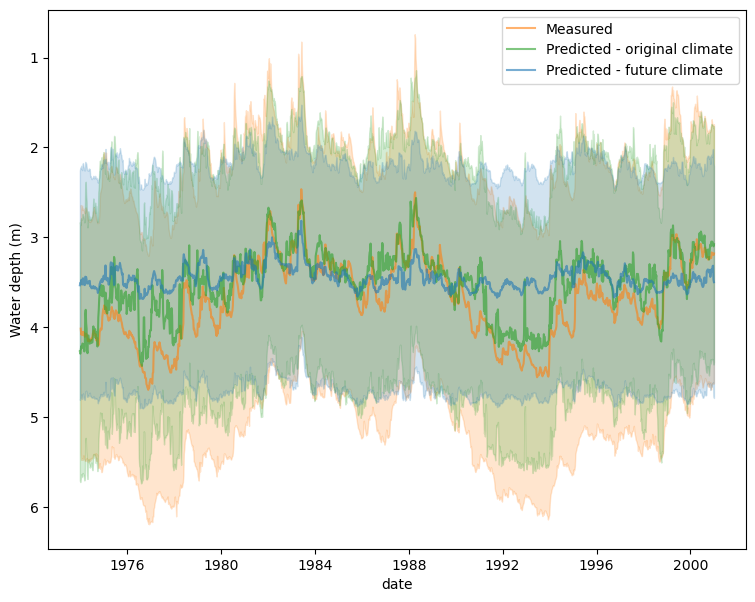

In [11]:
fig, ax = plt.subplots(figsize=(9,7), sharex=True)
ax.invert_yaxis()

sns.lineplot(data=past, x="date", y="water_depth", 
             errorbar='sd', color='tab:orange', alpha=0.6, ax=ax,
             label='Measured')
#sns.lineplot(data=past_weekly, x="date", y="pred_water_depth", 
#             errorbar='sd', color='tab:red', alpha=0.6, ax=ax,
#            label='Predicted - original climate')
sns.lineplot(data=base, x="date", y="pred_water_depth", 
             errorbar='sd', color='tab:green', alpha=0.6, ax=ax,
            label='Predicted - original climate')
sns.lineplot(data=pred, x="date", y="pred_water_depth", 
             errorbar='sd', color='tab:blue', alpha=0.6, ax=ax,
            label='Predicted - future climate')
ax.set_ylabel('Water depth (m)')

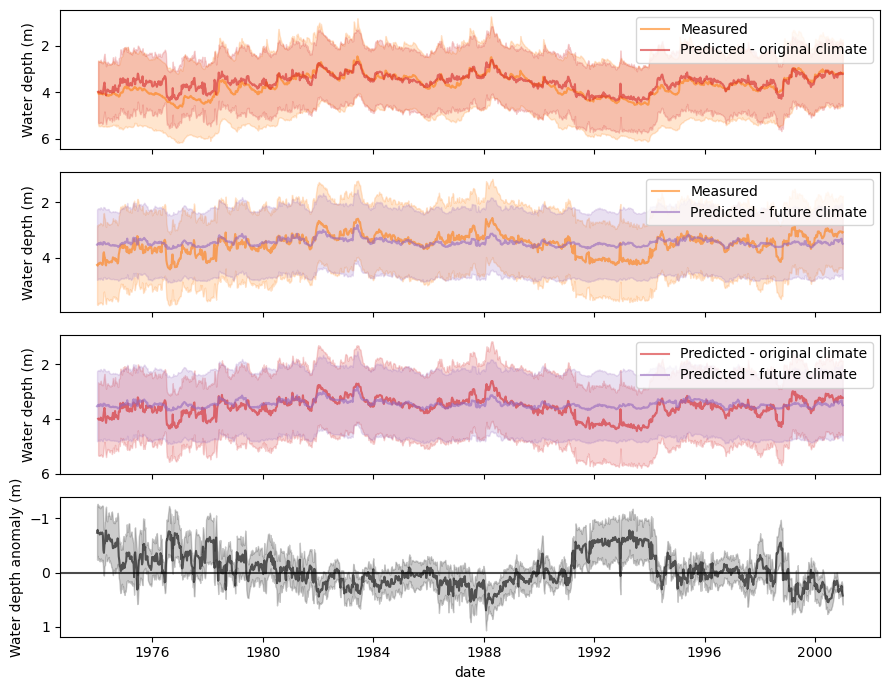

In [12]:
plot_compare_scenario(past, base, pred)

In [13]:
cl = 6
past_filtered = past.loc[past['reg_clusters'] == cl]
base_filtered = base.loc[base['reg_clusters'] == cl]
pred_filtered = pred.loc[pred['reg_clusters'] == cl]

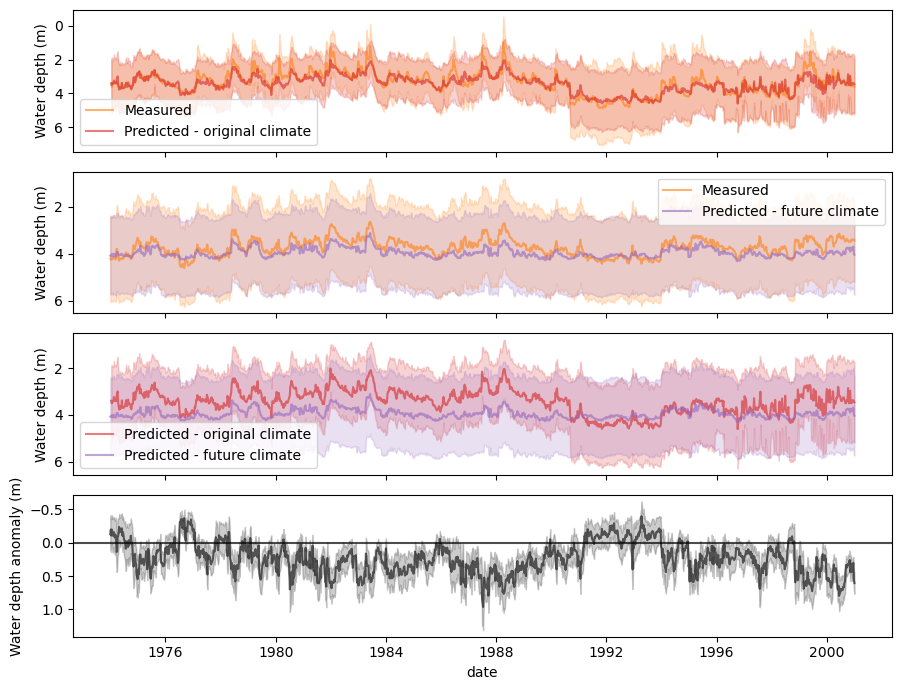

In [14]:
plot_compare_scenario(past_filtered, base_filtered, pred_filtered)

### Monthly

In [15]:
past = pasts['monthly']
pred = preds['monthly']
base = bases['monthly']

Text(0, 0.5, 'Water depth (m)')

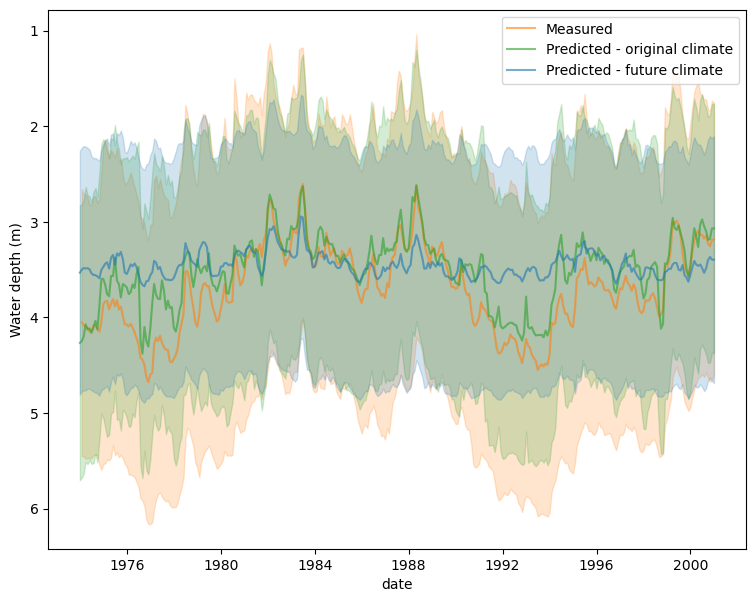

In [16]:
fig, ax = plt.subplots(figsize=(9,7), sharex=True)
ax.invert_yaxis()

sns.lineplot(data=past, x="date", y="water_depth", 
             errorbar='sd', color='tab:orange', alpha=0.6, ax=ax,
             label='Measured')
#sns.lineplot(data=past_weekly, x="date", y="pred_water_depth", 
#             errorbar='sd', color='tab:red', alpha=0.6, ax=ax,
#            label='Predicted - original climate')
sns.lineplot(data=base, x="date", y="pred_water_depth", 
             errorbar='sd', color='tab:green', alpha=0.6, ax=ax,
            label='Predicted - original climate')
sns.lineplot(data=pred, x="date", y="pred_water_depth", 
             errorbar='sd', color='tab:blue', alpha=0.6, ax=ax,
            label='Predicted - future climate')
ax.set_ylabel('Water depth (m)')

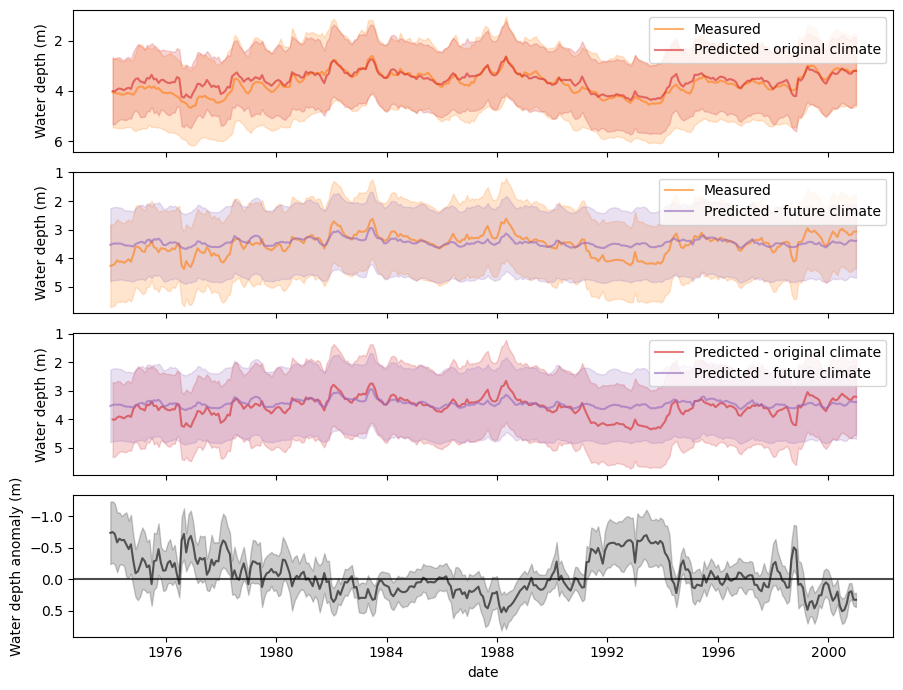

In [17]:
plot_compare_scenario(past, base, pred)

In [18]:
cl = 6
past_filtered = past.loc[past['reg_clusters'] == cl]
base_filtered = base.loc[base['reg_clusters'] == cl]
pred_filtered = pred.loc[pred['reg_clusters'] == cl]

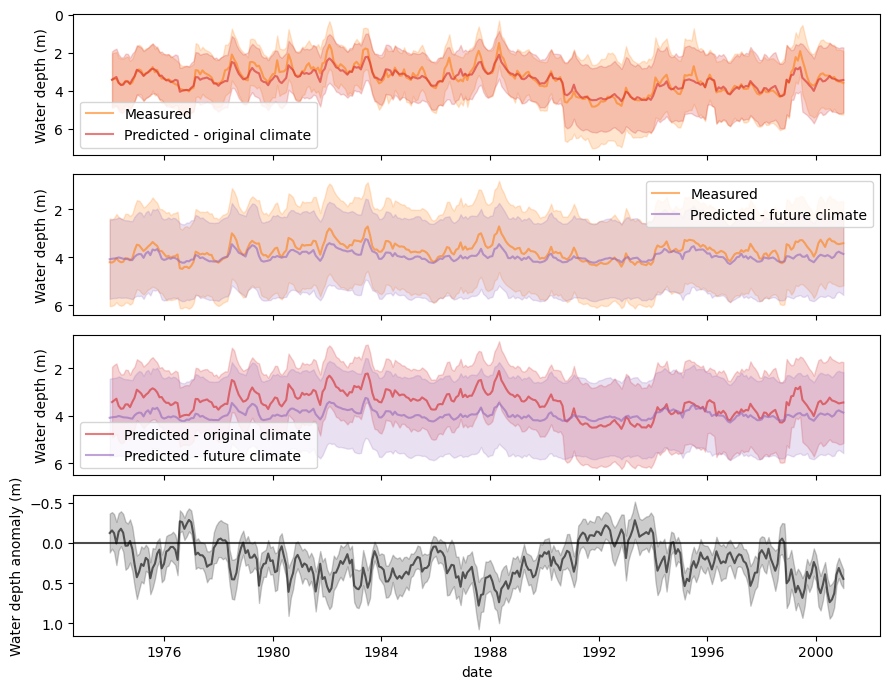

In [19]:
plot_compare_scenario(past_filtered, base_filtered, pred_filtered)

### Quarterly

In [20]:
past = pasts['quarterly']
pred = preds['quarterly']
base = bases['quarterly']

Text(0, 0.5, 'Water depth (m)')

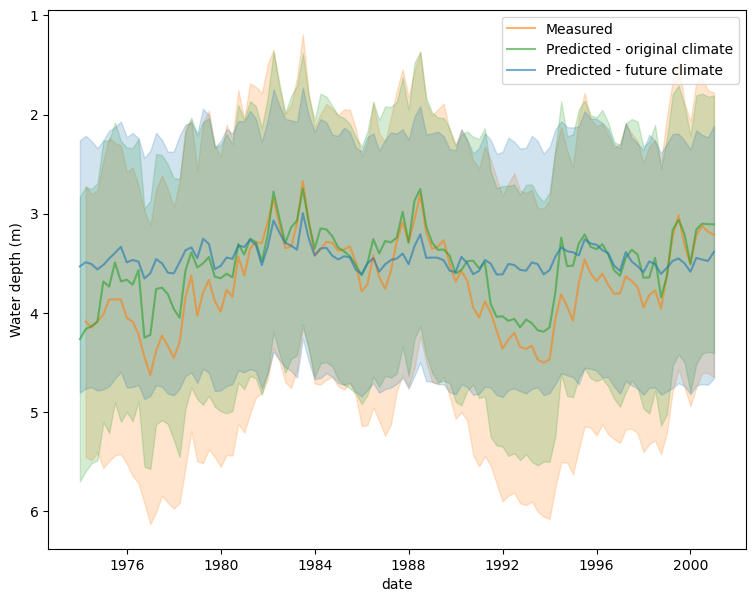

In [21]:
fig, ax = plt.subplots(figsize=(9,7), sharex=True)
ax.invert_yaxis()

sns.lineplot(data=past, x="date", y="water_depth", 
             errorbar='sd', color='tab:orange', alpha=0.6, ax=ax,
             label='Measured')
#sns.lineplot(data=past_weekly, x="date", y="pred_water_depth", 
#             errorbar='sd', color='tab:red', alpha=0.6, ax=ax,
#            label='Predicted - original climate')
sns.lineplot(data=base, x="date", y="pred_water_depth", 
             errorbar='sd', color='tab:green', alpha=0.6, ax=ax,
            label='Predicted - original climate')
sns.lineplot(data=pred, x="date", y="pred_water_depth", 
             errorbar='sd', color='tab:blue', alpha=0.6, ax=ax,
            label='Predicted - future climate')
ax.set_ylabel('Water depth (m)')

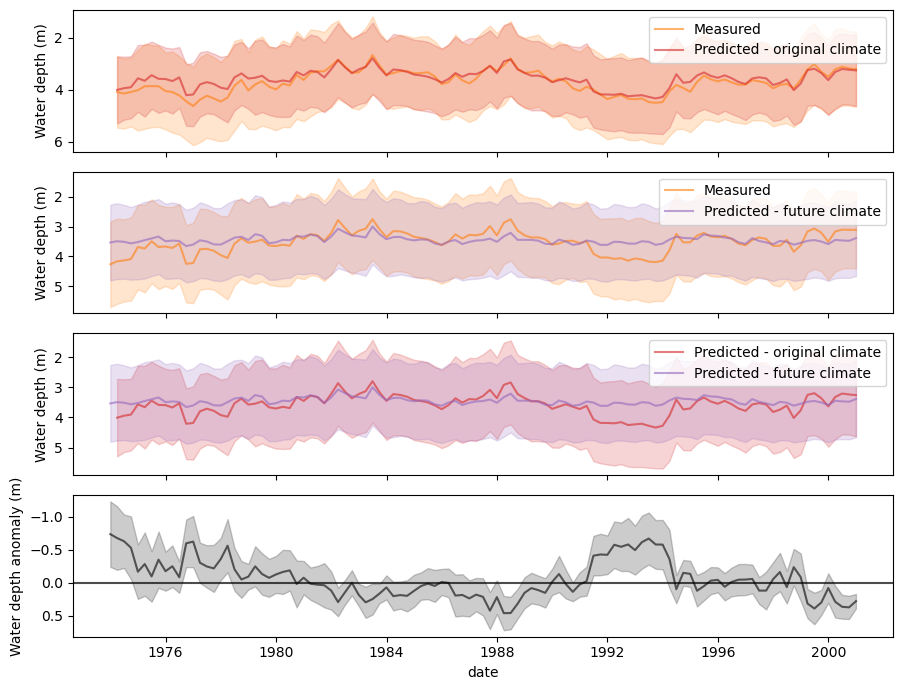

In [22]:
plot_compare_scenario(past, base, pred)

In [23]:
cl = 6
past_filtered = past.loc[past['reg_clusters'] == cl]
base_filtered = base.loc[base['reg_clusters'] == cl]
pred_filtered = pred.loc[pred['reg_clusters'] == cl]

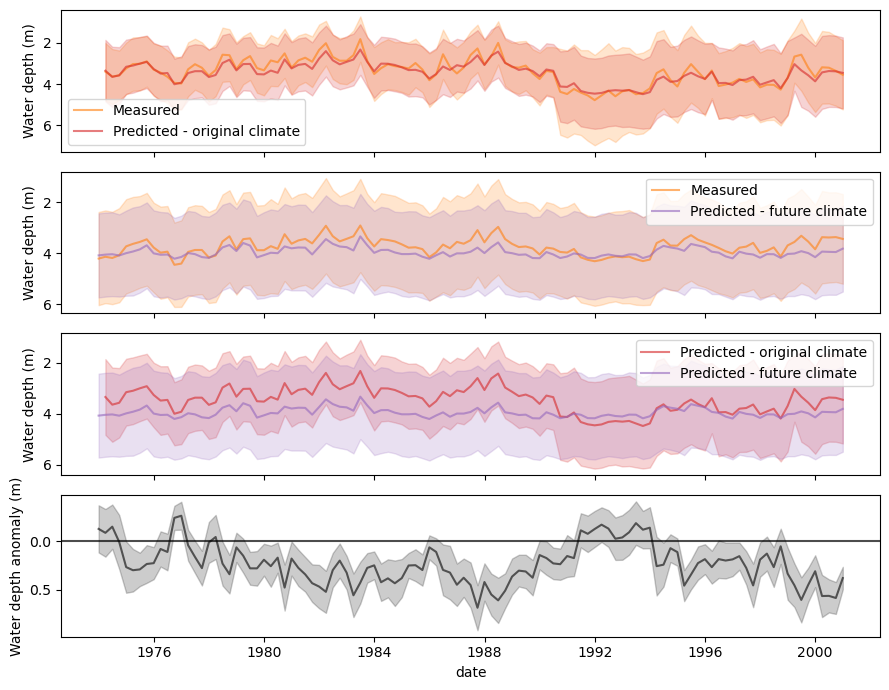

In [24]:
plot_compare_scenario(past_filtered, base_filtered, pred_filtered)

In [34]:
#past.columns

In [35]:
#past.loc[:, past.columns != 'geometry'].groupby(by=['station_id', 'date']).mean()

In [46]:
pred['date'].values[0]#[0]

numpy.datetime64('1973-12-31T00:00:00.000000000')

## Anomalies for all stations
neg. anomaly = scenario predicts shallower water than in ref scenario

In [49]:
# Load hillshade DEM
dem, dem_extent = load_dem('./data/dem/bergstraße30_shaded.tif')

In [50]:
#pred_weekly.loc[pred_weekly['date'] < pd.to_datetime('2000-10-29')].tail(10)

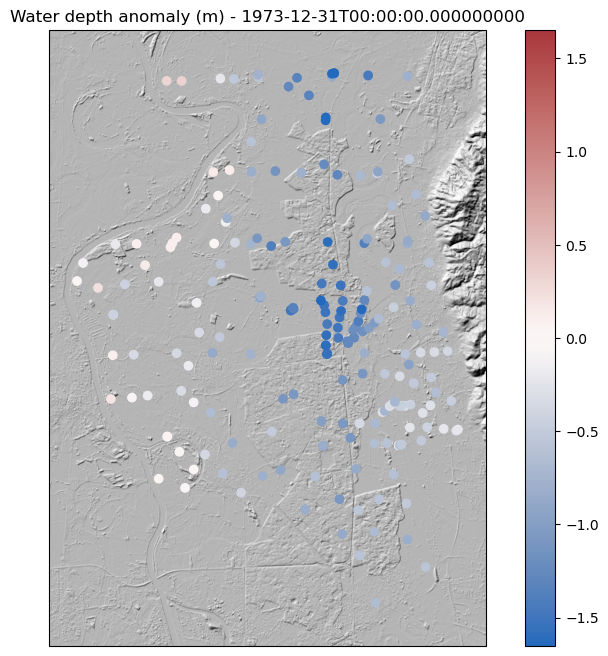

In [51]:
extent = pred.geometry.total_bounds
#date = pred.'2000-10-29'
date = pred['date'].values[0]
data = pred.loc[pred['date'] == pd.to_datetime(date)]
cmap = 'vlag'

# Create a figure and axis with a PlateCarree projection
fig, ax = plt.subplots(figsize=(10, 8), 
                       subplot_kw={'projection': ccrs.PlateCarree()} # removes axis labels
                      )

# Plot hillshade DEM
ax.imshow(dem, extent=(dem_extent[0], dem_extent[2],
                       dem_extent[1], dem_extent[3]),
          cmap='gray', origin='upper', aspect='auto')

data.plot(column='water_depth_anomaly',
            cmap=cmap, norm=colors.CenteredNorm(),
            legend=True, 
            ax=ax)

ax.set_xlim(extent[0]-0.02, extent[2]+0.02)
ax.set_ylim(extent[1]-0.02, extent[3]+0.02)

#ax.legend(loc='lower left', framealpha=0.5)

plt.title(f'Water depth anomaly (m) - {date}')
#plt.savefig('./figs/map_mean_water_depth_all_stations.png', bbox_inches='tight')

# Show the plot
plt.show()

## Interactive plots

In [ ]:
import plotly.graph_objects as go
import nbformat
print(nbformat.__version__)

In [ ]:
# Create a figure
fig = go.Figure()

# Add a trace for the entire dataset
fig.add_trace(go.Scatter(x=pred_weekly['date'], y=pred_weekly['water_depth_anomaly'],
                         mode='lines', name='Value'))

# Create a slider for date selection
steps = []
for date in pred_weekly['date'].unique():
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Date: " + str(date)}],
        label=str(date)
    )
    step["args"][0]["visible"][0] = True # Make the first trace visible
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Date: "},
    pad={"t": 50},
    steps=steps
)]

# Update layout to include sliders
fig.update_layout(
    sliders=sliders
)

# Show the figure
fig.show()